WorldPop develops peer-reviewed research and methods for the construction of open and high-resolution data on population distributions, demographic and dynamics with a focus on low and middle income countries. In this analysis we have used the Individual Countries 2000-2020 UN Adjusted data aggregated to 1 km resolution using 100 m resolution population counts dataset. Read more at [WorldPop](https://www.worldpop.org/geodata/listing?id=75)

[GADM](https://gadm.org/data.html) maps the administrative areas of all countries, at all levels of sub-division, providing data at high spatial resolutions that includes an extensive set of attributes. We have used the GADM data for India to demarcate the administrative boundaries.

In [134]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio import mask

import matplotlib.pyplot as plt
import numpy as np

import earthpy.plot as ep

from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

import plotly.express as px

In [2]:
india_administrative_boundaries = gpd.read_file('Data/gadm36_IND_shp/gadm36_IND_3.shp')

In [8]:
india_administrative_boundaries['NAME_1'].nunique()

36

In [25]:
india_administrative_boundaries['NAME_1'].unique()

array(['Andaman and Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli', 'Daman and Diu', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Lakshadweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland',
       'NCT of Delhi', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object)

In [9]:
india_administrative_boundaries['NAME_2'].nunique()

659

In [10]:
india_administrative_boundaries['NAME_3'].nunique()

2227

In [42]:
india_administrative_boundaries.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'NL_NAME_2', 'GID_3', 'NAME_3', 'VARNAME_3', 'NL_NAME_3', 'TYPE_3',
       'ENGTYPE_3', 'CC_3', 'HASC_3', 'geometry', 'population_count_wp'],
      dtype='object')

In [58]:
india_worldpop_raster_2020 = rasterio.open('Data/ind_ppp_2020_1km_Aggregated_UNadj.tif')

print('No. of bands:',(india_worldpop_raster_2020.count))
# Reading the first band, filtering negative raster values and visualise data with matplotlib
india_worldpop_raster_2020_tot = india_worldpop_raster_2020.read(1)
india_worldpop_raster_2020_tot[india_worldpop_raster_2020_tot<0] = None

india_worldpop_raster_2020_nonzero = india_worldpop_raster_2020_tot[india_worldpop_raster_2020_tot>0]
population_worldpop = india_worldpop_raster_2020_nonzero[india_worldpop_raster_2020_nonzero > 0].sum()
print('Total population - India (2020): ',round(population_worldpop/1000000000,2),'billion')

No. of bands: 1
Total population - India (2020):  1.38 billion


In [27]:
def get_population_count(vector_polygon,raster_layer):
    gtraster, bound = rasterio.mask.mask(raster_layer, [vector_polygon], crop=True)
    pop_estimate = gtraster[0][gtraster[0]>0].sum()
    return (pop_estimate.round(2))

In [30]:
%%time
india_administrative_boundaries['population_count_wp'] = india_administrative_boundaries['geometry'].apply(get_population_count,raster_layer=india_worldpop_raster_2020)


In [61]:
adm_boundaries = india_administrative_boundaries[['NAME_1','NAME_2','NAME_3','geometry']]

In [64]:
def get_year_pop(geometry,each_year=each_year):
    india_worldpop_raster_data = rasterio.open('Data/ind_ppp_'+str(each_year)+'_1km_Aggregated_UNadj.tif')
    year_pop = get_population_count(geometry,india_worldpop_raster_data)
    return year_pop
    

In [ ]:
%%time
for each_year in range(2000,2021,1):
    print(each_year)
    adm_boundaries['pop_'+str(each_year)] = adm_boundaries['geometry'].apply(get_year_pop,each_year=each_year)

In [119]:
with rasterio.open('Data/ind_ppp_2020_1km_Aggregated_UNadj.tif') as src:
    raster_2020 = src.read(1, masked=True)
    dsm_meta = src.profile

In [120]:
with rasterio.open('Data/ind_ppp_2000_1km_Aggregated_UNadj.tif') as src:
    raster_2000 = src.read(1, masked=True)

In [121]:
diff_pop = raster_2020 - raster_2000

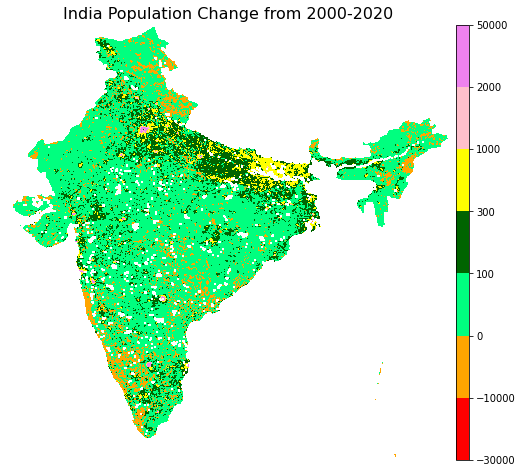

In [126]:
# Define the colors you want
cmap = ListedColormap(["red", "orange", "springgreen", "darkgreen","yellow","pink","violet"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([-30000, -10000, 0, 100, 300,1000, 2000,50000], 7)

fig, ax = plt.subplots(figsize=(12, 8))
chm_plot = ax.imshow(diff_pop, 
                     cmap=cmap, 
                     norm=norm)
ax.set_title("India Population Change from 2000-2020", fontsize=16)
ep.colorbar(chm_plot)
ax.set_axis_off()
plt.show()

In [127]:
with rasterio.open('data/pop_diff.tiff', 'w', **dsm_meta) as ff:
    ff.write(diff_pop,1)

In [128]:
sel_adm_level = 1
sel_adm = 'Telangana'

In [129]:
sel_location = adm_boundaries[adm_boundaries['NAME_'+str(sel_adm_level)]==sel_adm]

In [139]:
df_pop_sel = sel_location.groupby('NAME_1').sum().unstack().reset_index()
df_pop_sel['year'] = df_pop_sel['level_0'].apply(lambda x:x.split('_')[1])

In [142]:
df_pop_sel['pop_million'] = df_pop_sel[0].apply(lambda x:round(x/1000000,2))

In [154]:
fig = px.line(df_pop_sel,x='year',y='pop_million')
fig.update_xaxes(title='Year')
fig.update_yaxes(title='Population(Million)')
fig.update_layout(paper_bgcolor='white',plot_bgcolor='white',title='Population Count - '+sel_adm)